In [1]:
# import libraries

import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid # To build a grid of images that can be used to evaluate the image
from tqdm import tqdm # For Progress Bar while training
import matplotlib.pyplot as plt

In [2]:
# Function to display the grid with number of generated images to actual images

# Visualisation Function

def show(tensor, ch=1, size=(28,28), num=16):
  # tensor : 128 x 784 (why) the batch size will be 128 as we will be processing 128 images at a time and 784 because 28x28=784
  data = tensor.detach().cpu().view(-1, ch,*size) # to only visualize the content and not process it with the neural network

  ## view reshapes to 128 X 1 x 28 x 28 ( that is what explained in the above comment starting with tensor)
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) # 1 x 28 x 28 --> 28 x 28 x 1
  plt.imshow(grid)
  plt.show()

In [3]:
# setup of main parameters and hyperparameters
epochs = 500
cur_step = 0 # within epoch, how many steps
info_step = 300 # every how many steps we are going to show information on the screen
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 # dimetionality of the noise vector that is input to the generator
lr = 0.00001 # learning rate ## we will use ADAM Optimizer
loss_func = nn.BCEWithLogitsLoss()

bs = 128 # batch size
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

# number of steps = number_of_images_in_training_dataset/batch_size =  60000/128 = 468.75 == 469


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4565715.00it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 67593.82it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1279491.61it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10297583.12it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [37]:
# declare our models

# Generator
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True) # applying non linearity to learn complexity
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__() # initialize parent class
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256, 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
     return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

# Discriminatior
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1)
    )

  def forward(self, image):
    return self.disc(image)

In [38]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [39]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [40]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([9, 5, 6, 8, 8, 5, 5, 4, 6, 0])


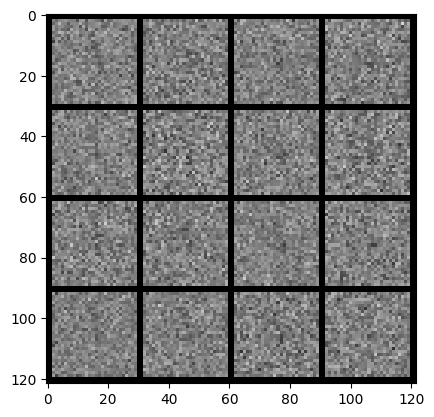

In [41]:
x,y=next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

# What you are seeing here is the initial output of passing the noise through the generator. Because the generator did not begin to learn, it produces a very noisy output

In [42]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets=torch.ones_like(pred)
    gen_loss=loss_func(pred, targets)

    return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach())
   disc_fake_targets=torch.zeros_like(disc_fake)
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss



 11%|█         | 51/469 [00:01<00:12, 32.28it/s]

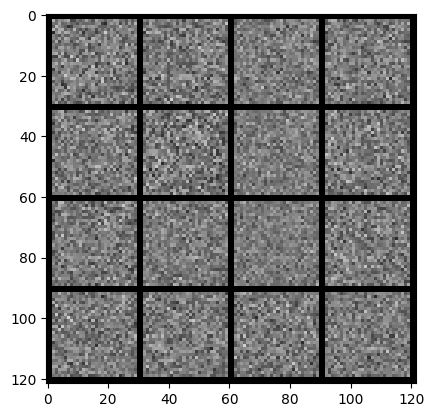

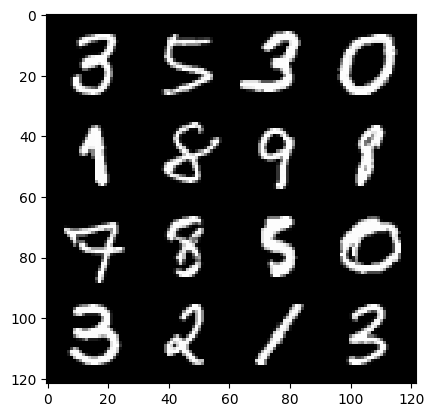

 13%|█▎        | 61/469 [00:02<00:17, 23.30it/s]

0: step 3900 / Gen loss: 4.820521473685904 / disc_loss: 0.1394748517529418


 75%|███████▌  | 352/469 [00:09<00:02, 48.04it/s]

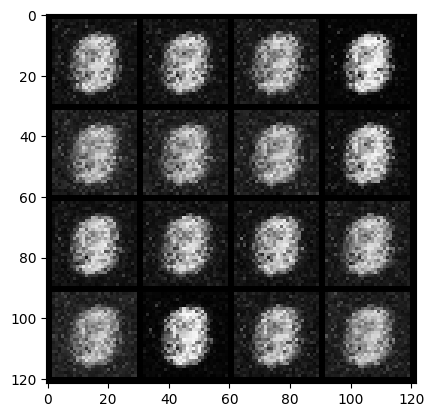

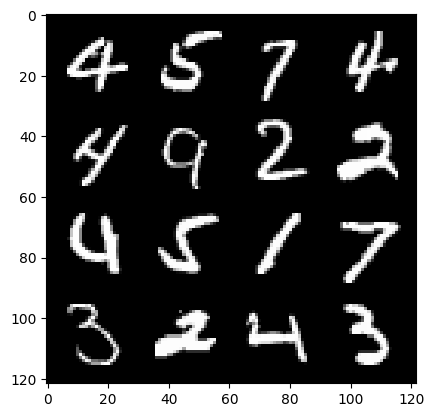

 77%|███████▋  | 362/469 [00:09<00:03, 27.15it/s]

0: step 4200 / Gen loss: 2.515447402397791 / disc_loss: 0.24055534258484845


 39%|███▉      | 184/469 [00:04<00:08, 35.07it/s]

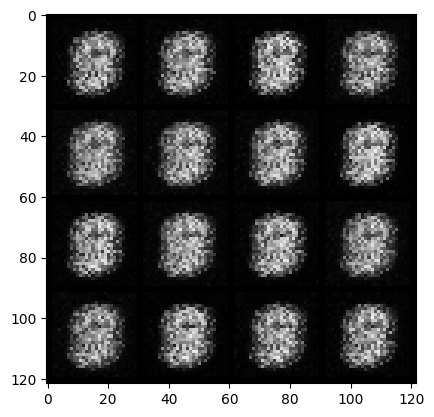

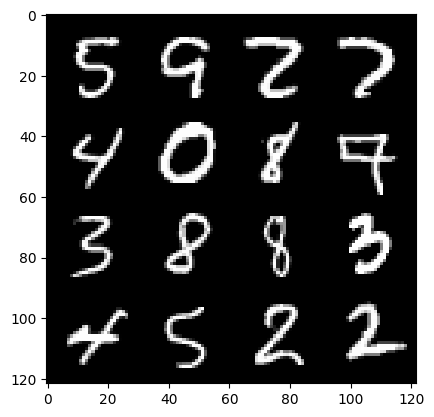

 41%|████      | 193/469 [00:05<00:16, 16.79it/s]

1: step 4500 / Gen loss: 3.477797083854677 / disc_loss: 0.10246321053554619


 93%|█████████▎| 437/469 [00:11<00:00, 46.55it/s]

In [ ]:
### 60000/128 = 468.75 = 469 steps in each epoch
### each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader): # The information that is returned at each point by the data loader structure, which is being wrapped by Tqdm, which is going to apply a beautiful progress bar to the visualization of the process. We are going to receive what we are going to receive a set of images that we are going to store in the variable real, because these are real images. These are images from the Mnist dataset, so they are the real images. And then we would also receive a set of labels, but we don't need the labels for anything because this is not supervised learning.
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real : 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

 ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization and stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1